# Installing and loading packages

In [0]:
# Install packages if not done already
import sys
!{sys.executable} -m pip install numpy matplotlib pandas sklearn nltk textblob bs4 keras
#Also in terminal: conda install tensorflow

In [1]:
#import required packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split , StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.externals import joblib
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0)

/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/Users/jj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

# Data preprocessing

In [0]:
#Method for preprocessing data (used for all except ULMFiT)
def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_no_short_words

## Loading data - only "New_data" in this case

In [2]:
#load and prepare new data
newdata=pd.read_csv('Input_data/New_data.csv')
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#Split category column 
newdata['category']=newdata['Categories'].apply(lambda x:x.split(';'))

def category_includer(data,string):    
    for i in range(len(data)):
        data.loc[i,string]=0
        column=list(data.loc[i,'category'])
        if string in column:
            data.loc[i,string]=1
    return data

newdata=category_includer(newdata,'experience')
newdata=category_includer(newdata,'service')
newdata=category_includer(newdata,'consistency')
newdata=category_includer(newdata,'value')
newdata=category_includer(newdata,'food')
newdata=category_includer(newdata,'convenience')

#dropping the two columns and filter only English
newdata=newdata.drop(['Categories','category'],axis=1)
newdata=newdata[newdata['Language']=="eng"]

In [3]:
#To make a list of stopwords to exclude, but best results achieved without stopwords
"""
nltk.download('stopwords')
stops_nlp = set(stopwords.words('english')) 
stops_1 = ["a's" , "able" , "about" , "above" , "according" , "accordingly" , "across" , "actually" , "after" , "afterwards" , "again" , "against" , "ain't" , "all" , "allow" , "allows" , "almost" , "alone" , "along" , "already" , "also" , "although" , "always" , "am" , "among" , "amongst" , "an" , "and" , "another" , "any" , "anybody" , "anyhow" , "anyone" , "anything" , "anyway" , "anyways" , "anywhere" , "apart" , "appear" , "appreciate" , "appropriate" , "are" , "aren't" , "around" , "as" , "aside" , "ask" , "asking" , "associated" , "at" , "available" , "away" , "awfully" , "be" , "became" , "because" , "become" , "becomes" , "becoming" , "been" , "before" , "beforehand" , "behind" , "being" , "believe" , "below" , "beside" , "besides" , "best" , "better" , "between" , "beyond" , "both" , "brief" , "but" , "by" , "c'mon" , "c's" , "came" , "can" , "can't" , "cannot" , "cant" , "cause" , "causes" , "certain" , "certainly" , "changes" , "clearly" , "co" , "com" , "come" , "comes" , "concerning" , "consequently" , "consider" , "considering" , "contain" , "containing" , "contains" , "corresponding" , "could" , "couldn't" , "course" , "currently" , "definitely" , "described" , "despite" , "did" , "didn't" , "different" , "do" , "does" , "doesn't" , "doing" , "don't" , "done" , "down" , "downwards" , "during" , "each" , "edu" , "eg" , "eight" , "either" , "else" , "elsewhere" , "enough" , "entirely" , "especially" , "et" , "etc" , "even" , "ever" , "every" , "everybody" , "everyone" , "everything" , "everywhere" , "ex" , "exactly" , "example" , "except" , "far" , "few" , "fifth" , "first" , "five" , "followed" , "following" , "follows" , "for" , "former" , "formerly" , "forth" , "four" , "from" , "further" , "furthermore" , "get" , "gets" , "getting" , "given" , "gives" , "go" , "goes" , "going" , "gone" , "got" , "gotten" , "greetings" , "had" , "hadn't" , "happens" , "hardly" , "has" , "hasn't" , "have" , "haven't" , "having" , "he" , "he's" , "hello" , "help" , "hence" , "her" , "here" , "here's" , "hereafter" , "hereby" , "herein" , "hereupon" , "hers" , "herself" , "hi" , "him" , "himself" , "his" , "hither" , "hopefully" , "how" , "howbeit" , "however" , "i'd" , "i'll" , "i'm" , "i've" , "ie" , "if" , "ignored" , "immediate" , "in" , "inasmuch" , "inc" , "indeed" , "indicate" , "indicated" , "indicates" , "inner" , "insofar" , "instead" , "into" , "inward" , "is" , "isn't" , "it" , "it'd" , "it'll" , "it's" , "its" , "itself" , "just" , "keep" , "keeps" , "kept" , "know" , "known" , "knows" , "last" , "lately" , "later" , "latter" , "latterly" , "least" , "less" , "lest" , "let" , "let's" , "like" , "liked" , "likely" , "little" , "look" , "looking" , "looks" , "ltd" , "mainly" , "many" , "may" , "maybe" , "me" , "mean" , "meanwhile" , "merely" , "might" , "more" , "moreover" , "most" , "mostly" , "much" , "must" , "my" , "myself" , "name" , "namely" , "nd" , "near" , "nearly" , "necessary" , "need" , "needs" , "neither" , "never" , "nevertheless" , "new" , "next" , "nine" , "no" , "nobody" , "non" , "none" , "noone" , "nor" , "normally" , "not" , "nothing" , "novel" , "now" , "nowhere" , "obviously" , "of" , "off" , "often" , "oh" , "ok" , "okay" , "old" , "on" , "once" , "one" , "ones" , "only" , "onto" , "or" , "other" , "others" , "otherwise" , "ought" , "our" , "ours" , "ourselves" , "out" , "outside" , "over" , "overall" , "own" , "particular" , "particularly" , "per" , "perhaps" , "placed" , "please" , "plus" , "possible" , "presumably" , "probably" , "provides" , "que" , "quite" , "qv" , "rather" , "rd" , "re" , "really" , "reasonably" , "regarding" , "regardless" , "regards" , "relatively" , "respectively" , "right" , "said" , "same" , "saw" , "say" , "saying" , "says" , "second" , "secondly" , "see" , "seeing" , "seem" , "seemed" , "seeming" , "seems" , "seen" , "self" , "selves" , "sensible" , "sent" , "serious" , "seriously" , "seven" , "several" , "shall" , "she" , "should" , "shouldn't" , "since" , "six" , "so" , "some" , "somebody" , "somehow" , "someone" , "something" , "sometime" , "sometimes" , "somewhat" , "somewhere" , "soon" , "sorry" , "specified" , "specify" , "specifying" , "still" , "sub" , "such" , "sup" , "sure" , "t's" , "take" , "taken" , "tell" , "tends" , "th" , "than" , "thank" , "thanks" , "thanx" , "that" , "that's" , "thats" , "the" , "their" , "theirs" , "them" , "themselves" , "then" , "thence" , "there" , "there's" , "thereafter" , "thereby" , "therefore" , "therein" , "theres" , "thereupon" , "these" , "they" , "they'd" , "they'll" , "they're" , "they've" , "think" , "third" , "this" , "thorough" , "thoroughly" , "those" , "though" , "three" , "through" , "throughout" , "thru" , "thus" , "to" , "together" , "too" , "took" , "toward" , "towards" , "tried" , "tries" , "truly" , "try" , "trying" , "twice" , "two" , "un" , "under" , "unfortunately" , "unless" , "unlikely" , "until" , "unto" , "up" , "upon" , "us" , "use" , "used" , "useful" , "uses" , "using" , "usually" , "value" , "various" , "very" , "via" , "viz" , "vs" , "want" , "wants" , "was" , "wasn't" , "way" , "we" , "we'd" , "we'll" , "we're" , "we've" , "welcome" , "well" , "went" , "were" , "weren't" , "what" , "what's" , "whatever" , "when" , "whence" , "whenever" , "where" , "where's" , "whereafter" , "whereas" , "whereby" , "wherein" , "whereupon" , "wherever" , "whether" , "which" , "while" , "whither" , "who" , "who's" , "whoever" , "whole" , "whom" , "whose" , "why" , "will" , "willing" , "wish" , "with" , "within" , "without" , "won't" , "wonder" , "would" , "wouldn't" , "yes" , "yet" , "you" , "you'd" , "you'll" , "you're" , "you've" , "your" , "yours" , "yourself" , "yourselves" , "zero"]
stops_2=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stops_spacy = STOP_WORDS
stops_nlp=list(stops_nlp)
stops_nlp.extend(stops_1)
stops_nlp.extend(stops_2)
stops_nlp=set(stops_nlp)
stops=stops_nlp.union(stops_spacy)
"""
#Using no stopwords
stops={}

## Model definitions

In [0]:
#define the models, parameters for grid search and their names.
"""
#List of all models in reasonably large range
models = [ LogisticRegression(class_weight='balanced'),
     SVC(class_weight='balanced'),
     RandomForestClassifier(class_weight='balanced',random_state=0),
     GradientBoostingClassifier(),
     MultinomialNB()
         ]
params = [ 
     { 'C': [0.01,0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]},
     [
        {'kernel': ['linear'], 'C': np.linspace(0.1,10,5)},
        {'kernel': ['rbf'], 'C': np.linspace(0.1,10,5), 'gamma': np.linspace(0.001,1,5)},
    ],
    {'max_depth':list(range(5,15,5)),'n_estimators':[100,200]},
    {'n_estimators':[100,200],'learning_rate':[0.01,0.02],'max_depth':list(range(1,15,3))},
    {}
    
]

#1 example model each for testing
"""
models = [ LogisticRegression(class_weight='balanced'),
     SVC(class_weight='balanced'),
     RandomForestClassifier(class_weight='balanced',random_state=0),
     GradientBoostingClassifier(),
     MultinomialNB()
         ]
params = [ 
     { 'C': [0.01]},
     [
        #{'kernel': ['linear'], 'C': np.linspace(0.1,10,5)},
        {'kernel': ['rbf'], 'C': [2.3], 'gamma': [1]},
    ],
    {'max_depth':[5],'n_estimators':[100]},
    {'n_estimators':[100],'learning_rate':[0.01],'max_depth':[7]},
    {}
    
]

names=['LogisticRegression','SVM','RandomForest','GradientBoostingClassifier','MultinomialNB']
#the function iterates for all the models and selects the model with the highest score for the test set. The model is fitted on the training set.




In [0]:
#Method to select the best model
def select_best_model(X_train,y_train,X_test,y_test):
    param_matrix={}
    score=0
    for model,param,name in zip(models,params,names):
        gs_model=GridSearchCV(model,param,refit=True,n_jobs=-1,verbose=25)
        print(name)
        gs_model.fit(X_train,y_train)
        predictions=gs_model.predict(X_test)
        param_matrix[name]=accuracy_score(y_test,predictions)    
        if accuracy_score(y_test,predictions)>score:
            score=accuracy_score(y_test,predictions)
            best_model=gs_model
    return best_model

# Sentiment

## Data preparation for classical models


In [0]:
# Preparing data for sentiment - classical models and LSTM

#reviews and sentiment as values
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#test train split
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews_new, sentiment_new, test_size=0.2,random_state=0,stratify=sentiment_new)

#bag of words
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(reviews_train)):
    reviews_train[i] = text_preprocessing(reviews_train[i], language, minWordLength)
for i in range(len(reviews_test)):
    reviews_test[i] = text_preprocessing(reviews_test[i], language, minWordLength)
        
count_vect = CountVectorizer(ngram_range=(1,3),max_features=20000)
tfidf_transformer = TfidfTransformer(use_idf=True)
    
count_vect.fit(reviews_train)
text_train_bow = count_vect.transform(reviews_train)
text_test_bow = count_vect.transform(reviews_test)
    
tfidf_transformer.fit_transform(text_train_bow)
reviews_bow_train = tfidf_transformer.transform(text_train_bow)
reviews_bow_test = tfidf_transformer.transform(text_test_bow)
joblib.dump(count_vect,'Exported_models/count_vectorizer_newtrain_newtest_sentiment.pkl')
joblib.dump(tfidf_transformer,'Exported_models/tfidftransformer_newtrain_newtest_sentiment.pkl')


/Users/jj/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['Exported_models/tfidftransformer_newtrain_newtest_sentiment']

## Training Sentiment classical models + export optimal

In [0]:
#training the classical models
print('training to find sentiment'+'\n')
best_model_reviews = select_best_model(reviews_bow_train,sentiment_train,reviews_bow_test,sentiment_test)

#testing the models
print('Testing on sentiment prediction'+ '\n\n'+ 'best parameters:')
print(best_model_reviews.best_estimator_)
print('\n')
print('Classification report:')
y_pred_reviews = best_model_reviews.predict(reviews_bow_test)

print(classification_report(sentiment_test, y_pred_reviews))

cf_sentiment = confusion_matrix(sentiment_test, y_pred_reviews)
print(cf_sentiment)
print(accuracy_score(sentiment_test, y_pred_reviews) * 100)

#Exporting the models
joblib.dump(best_model_reviews.best_estimator_, 'Exported_models/train_new_test_new_sentiment_bestmodel_classical.pkl')
joblib.dump(best_model_reviews, 'Exported_models/train_new_test_new_sentiment_classical.pkl')

training to find sentiment

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarn

SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.7s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Testing on sentiment prediction

best parameters:
SVC(C=2.3, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


Classification report:


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0292s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


              precision    recall  f1-score   support

          -1       0.82      0.79      0.81       177
           0       0.88      0.23      0.37        60
           1       0.92      0.98      0.95       749

    accuracy                           0.90       986
   macro avg       0.87      0.67      0.71       986
weighted avg       0.90      0.90      0.89       986

[[140   1  36]
 [ 16  14  30]
 [ 14   1 734]]
90.06085192697769


['Exported_models/train_new_test_new_sentiment_classical.pkl']

# Data preparation for LSTM

In [10]:
reviews=newdata['Text'].values
sentiment=newdata['Sentiment'].values

#Split in train and test samples
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews,sentiment, test_size=0.2,random_state=0,stratify=sentiment)

#tokenize the reviews and remove punctuations and convert to lower case
tk = Tokenizer(lower = True,filters=punctuation)
#fit on the training data and transform the test data
tk.fit_on_texts(reviews_train)
X_seq = tk.texts_to_sequences(reviews_train)
#select only the first 100 words of the review and ignore the words after that. If review is less than 100 words then add zeroes to get a length of 100.
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
X_seq_test = tk.texts_to_sequences(reviews_test)
X_pad_test = pad_sequences(X_seq_test, maxlen=100, padding='post')
#save the tokenizer model as a pickle file.
joblib.dump(tk,"Exported_models/train_new_test_new_sentiment_tokenizer_LSTM.pkl")

['Exported_models/train_new_test_new_sentiment_tokenizer_LSTM.pkl']

## Training Sentiment LSTM model + export

/Users/jj/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 3549 samples, validate on 395 samples
Epoch 1/60
3549/3549 [==============================] - 41s 12ms/step - loss: 0.7356 - categorical_accuracy: 0.7597 - val_loss: 0.7159 - val_categorical_accuracy: 0.7367
Epoch 2/60
3549/3549 [==============================] - 51s 14ms/step - loss: 0.6541 - categorical_accuracy: 0.7689 - val_loss: 0.6948 - val_categorical_accuracy: 0.7696
Epoch 3/60
3549/3549 [==============================] - 41s 12ms/step - loss: 0.6326 - categorical_accuracy: 0.7537 - val_loss: 0.7528 - val_categorical_accuracy: 0.7367
Epoch 4/60
3549/3549 [==============================] - 38s 11ms/step - loss: 0.6364 - categorical_accuracy: 0.7622 - val_loss: 0.6967 - val_categorical_accuracy: 0.7367
Epoch 5/60
3549/3549 [==============================] - 44s 13ms/step - loss: 0.6259 - categorical_accuracy: 0.7622 - val_loss: 0.6971 - val_categorical_accuracy: 0.7367
Epoch 6/60
3549/3549 [==============================] - 35s 10ms/step - loss: 0.6193 - categorical_accu

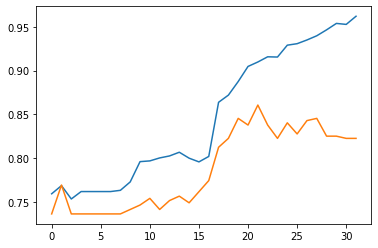

In [11]:
#define the LSTM model. 
vocabulary_size = len(tk.word_counts.keys())+1
max_words = 100
embedding_size = 200
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(200))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#convert the sentiment values to dummies using one hot encoding
sentiment_train2 = pd.get_dummies(sentiment_train).values

# early stopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#save the best model automatically. The model saved has the lowest validation loss.
mcp_save = ModelCheckpoint('Exported_models/train_new_test_new_sentiment_bestmodel_LSTM.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')

history=model.fit(X_pad,sentiment_train2, batch_size=100, epochs=60, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1)

#plot history

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])


In [17]:
# Test and print results
#load1_model = load_model('/content/drive/train_new_test_new_sentiment_bestmodel_LSTM.h5')
y_pred_reviews=model.predict(X_pad_test, verbose=100)
y_pred_reviews2=y_pred_reviews.copy()
labels = [-1,0,1]
for i in range(len(y_pred_reviews2)):
    y_pred_reviews2[i,0]= labels[np.argmax(y_pred_reviews2[i])]
y_pred_reviews3=y_pred_reviews2[:,0]

print(classification_report(sentiment_test, y_pred_reviews3))
cf_sentiment = confusion_matrix(sentiment_test, y_pred_reviews3)
print(cf_sentiment)

              precision    recall  f1-score   support

          -1       0.72      0.78      0.75       177
           0       0.24      0.28      0.26        60
           1       0.94      0.91      0.93       749

    accuracy                           0.85       986
   macro avg       0.63      0.66      0.65       986
weighted avg       0.86      0.85      0.85       986

[[138  18  21]
 [ 24  17  19]
 [ 30  36 683]]


In [16]:
#predict on a review
new_review=np.array(['This is a great restaurant to visit'])
#Use tokenizer and padding
padded_review=pad_sequences(tk.texts_to_sequences(new_review), maxlen=100, padding='post')
#predict the review
labels=[-1,0,1]
labels[np.argmax(model.predict(padded_review))]

1

Please note: need to use different API for LSTM, which will likely need more resources and run slower

# Classification

## Training classification classical models + export optimal

In [0]:
#training and testing on the new data

#CLassification 

random_state = 0
test_size = 0.2 # test set is 20% of the total data set
text_train,text_test,y_train,y_test=train_test_split(newdata['Text'].values,newdata[['food','experience','value','service','consistency','convenience']],random_state=0,test_size=0.2)


# Make bag of words feature vectors
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(text_train)):
    text_train[i] = text_preprocessing(text_train[i], language, minWordLength)
for i in range(len(text_test)):
    text_test[i] = text_preprocessing(text_test[i], language, minWordLength)
        
count_vect = CountVectorizer(ngram_range=(1,3),max_features=20000)
tfidf_transformer = TfidfTransformer(use_idf=True)
    
count_vect.fit(text_train)
text_train_bow = count_vect.transform(text_train)
text_test_bow = count_vect.transform(text_test)
    
tfidf_transformer.fit_transform(text_train_bow)
reviews_bow_train = tfidf_transformer.transform(text_train_bow)
reviews_bow_test = tfidf_transformer.transform(text_test_bow)
joblib.dump(count_vect,'Exported_models/count_vectorizer_newtrain_newtest_classification.pkl')
joblib.dump(tfidf_transformer,'Exported_models/tfidftransformer_newtrain_newtest_classification.pkl')

#training for the various choice drivers
print('Training model on choice driver food'+'\n')
best_model_food = select_best_model(reviews_bow_train,y_train['food'].values,reviews_bow_test,y_test['food'].values)
print('Training model on choice driver experience' +'\n')
best_model_experience = select_best_model(reviews_bow_train, y_train['experience'].values,reviews_bow_test,y_test['experience'].values)
print('Training model on choice driver value' +'\n')
best_model_value = select_best_model(reviews_bow_train, y_train['value'].values,reviews_bow_test,y_test['value'].values)
print('Training model on choice driver service' +'\n')
best_model_service = select_best_model(reviews_bow_train, y_train['service'].values,reviews_bow_test,y_test['service'].values)
print('Training model on choice driver convenience' +'\n')
best_model_convenience = select_best_model(reviews_bow_train, y_train['convenience'].values,reviews_bow_test,y_test['convenience'].values)
print('Training model on choice driver consistency' +'\n')
best_model_consistency = select_best_model(reviews_bow_train, y_train['consistency'].values,reviews_bow_test,y_test['consistency'].values)


# Testing on test set
print('Testing on choice driver food'+ '\n\n' + 'best parameters:')
print( best_model_food.best_estimator_ )
print('\n')
y_test_food = y_test['food'].values
print('Classification report:')
y_pred_food = best_model_food.predict(reviews_bow_test)
print(classification_report(y_test_food, y_pred_food))
cf_food = confusion_matrix(y_test_food, y_pred_food)
print(cf_food)
print(accuracy_score(y_test_food, y_pred_food) * 100)

print('---------------------------------------------')
y_test_experience = y_test['experience'].values
print('Testing on choice driver experience'+ '\n\n'+ 'best parameters:')
print(best_model_experience.best_estimator_)
print('\n')
print('Classification report:')
y_pred_experience = best_model_experience.predict(reviews_bow_test)
print(classification_report(y_test_experience, y_pred_experience))
cf_experience = confusion_matrix(y_test_experience, y_pred_experience)
print(cf_experience)
print(accuracy_score(y_test_experience, y_pred_experience) * 100)

print('---------------------------------------------')

print('Testing on choice driver value'+ '\n\n'+ 'best parameters:')
y_test_value = y_test['value'].values
print(best_model_value.best_estimator_)
print('\n')
print('Classification report:')
y_pred_value = best_model_value.predict(reviews_bow_test)
print(classification_report(y_test_value, y_pred_value))
cf_value = confusion_matrix(y_test_value, y_pred_value)
print(cf_value)
print(accuracy_score(y_test_value, y_pred_value) * 100)

print('---------------------------------------------')

print('Testing on choice driver service'+ '\n\n'+ 'best parameters:')
y_test_service = y_test['service'].values
print(best_model_service.best_estimator_)
print('\n')
print('Classification report:')
y_pred_service = best_model_service.predict(reviews_bow_test)
print(classification_report(y_test_service, y_pred_service))
cf_service = confusion_matrix(y_test_service, y_pred_service)
print(cf_service)
print(accuracy_score(y_test_service, y_pred_service) * 100)

print('---------------------------------------------')

print('Testing on choice driver consistency'+ '\n\n'+ 'best parameters:')
y_test_consistency = y_test['consistency'].values
print(best_model_consistency.best_estimator_)
print('\n')
print('Classification report:')
y_pred_consistency = best_model_consistency.predict(reviews_bow_test)
print(classification_report(y_test_consistency, y_pred_consistency))
cf_consistency = confusion_matrix(y_test_consistency, y_pred_consistency)
print(cf_consistency)
print(accuracy_score(y_test_consistency, y_pred_consistency) * 100)

print('---------------------------------------------')



print('Testing on choice driver convenience'+ '\n\n'+ 'best parameters:')
y_test_convenience = y_test['convenience'].values
print(best_model_convenience.best_estimator_)
print('\n')
print('Classification report:')
y_pred_convenience = best_model_convenience.predict(reviews_bow_test)
print(classification_report(y_test_convenience, y_pred_convenience))
cf_convenience = confusion_matrix(y_test_convenience, y_pred_convenience)
print(cf_convenience)
print(accuracy_score(y_test_convenience, y_pred_convenience) * 100)



joblib.dump(best_model_food.best_estimator_, 'Exported_models/train_new_test_new_food_bestmodel.pkl')
joblib.dump(best_model_food, 'Exported_models/train_new_test_new_food.pkl')
joblib.dump(best_model_consistency.best_estimator_, 'Exported_models/train_new_test_new_consistency_bestmodel.pkl')
joblib.dump(best_model_consistency, 'Exported_models/train_new_test_new_consistency.pkl')
joblib.dump(best_model_convenience.best_estimator_, 'Exported_models/train_new_test_new_convenience_bestmodel.pkl')
joblib.dump(best_model_convenience, 'Exported_models/train_new_test_new_convenience.pkl')
joblib.dump(best_model_experience.best_estimator_, 'Exported_models/train_new_test_new_experience_bestmodel.pkl')
joblib.dump(best_model_experience, 'Exported_models/train_new_test_new_experience.pkl')
joblib.dump(best_model_service.best_estimator_, 'Exported_models/train_new_test_new_service_bestmodel.pkl')
joblib.dump(best_model_service, 'Exported_models/train_new_test_new_service.pkl')
joblib.dump(best_model_value.best_estimator_, 'Exported_models/train_new_test_new_value_bestmodel.pkl')
joblib.dump(best_model_value, 'Exported_models/train_new_test_new_value.pkl')


/Users/jj/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Training model on choice driver food

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING

SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training model on choice driver experience

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0299s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ta

RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training model on choice driver value

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0262s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ta

RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.7s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training model on choice driver service

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0190s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ta

RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training model on choice driver convenience

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0216s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ta

RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training model on choice driver consistency

LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVM
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0255s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ta

RandomForest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


GradientBoostingClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished


MultinomialNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Testing on choice driver food

best parameters:
SVC(C=2.3, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


Classification report:


/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0274s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.75      0.45      0.56       301
         1.0       0.80      0.93      0.86       685

    accuracy                           0.79       986
   macro avg       0.77      0.69      0.71       986
weighted avg       0.78      0.79      0.77       986

[[136 165]
 [ 45 640]]
78.70182555780933
---------------------------------------------
Testing on choice driver experience

best parameters:
SVC(C=2.3, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75       463
         1.0       0.76      0.87      0.81       523

    accuracy                           0.78       986
   macro avg       0.79      0.78      0.78       986
wei

/Users/jj/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['Exported_models/train_new_test_new_value.pkl']